Test with Acropora abrolhosensis https://www.marinespecies.org/aphia.php?p=taxdetails&id=288182
aphiaID = 288182  
urn = urn:lsid:marinespecies.org:taxname:288182

In [1]:
import json
from urllib.request import urlopen
import urllib.parse
import pandas as pd

In [18]:
base = 'https://api.obis.org/v3/'

aphiaID = '288182'

fields = ['decimalLatitude','decimalLongitude','occurrenceID','id',
          'datasetName','dataset_id','eventDate','species','aphiaID',
          'date_year']

f = "%2C".join([f"{v}" for v in fields])

# define a polygon
# bound it somehow to between 30 deg N and S latitude
geometry=urllib.parse.quote("POLYGON ((-180 -30, 180 -30, 180 30, -180 30, -180 -30))")

depth = [0, 30]

# How many responses do you want back? Max=10000
size = 1000

occurrence_id = 'occurrence?taxonid={}&startdepth={}&enddepth={}&geometry={}&size={}'.format(aphiaID,depth[0],depth[1],geometry,size)

#taxon_id = 'taxon/{}'.format(aphiaID)
#taxon_sn = 'taxon/{}'.format(scientificname)

url = '{}{}'.format(base,occurrence_id)

url

'https://api.obis.org/v3/occurrence?taxonid=288182&startdepth=0&enddepth=30&geometry=POLYGON%20%28%28-180%20-30%2C%20180%20-30%2C%20180%2030%2C%20-180%2030%2C%20-180%20-30%29%29&size=1000'

In [22]:
response= urlopen(url)

data_json = json.loads(response.read())

data = pd.DataFrame(data_json['results'])

size = data_json['total']

print("Found %i records." % size)
print("See in mapper at: %s" % '{}{}#'.format('https://mapper.obis.org/?',occurrence_id.replace("occurrence?","")))

Found 10 records.
See in mapper at: https://mapper.obis.org/?taxonid=288182&startdepth=0&enddepth=30&geometry=POLYGON%20%28%28-180%20-30%2C%20180%20-30%2C%20180%2030%2C%20-180%2030%2C%20-180%20-30%29%29&size=1000#


In [16]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.decimalLongitude, data.decimalLatitude),
    crs="EPSG:4326")

C:\Users\Mathew.Biddle\programs\Anaconda3\envs\sandbox\lib\site-packages\IPython\core\interactiveshell.py:3377: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


(-18491143.68863403, 18491143.68863403, -9473562.580980353, 9191411.568387408)

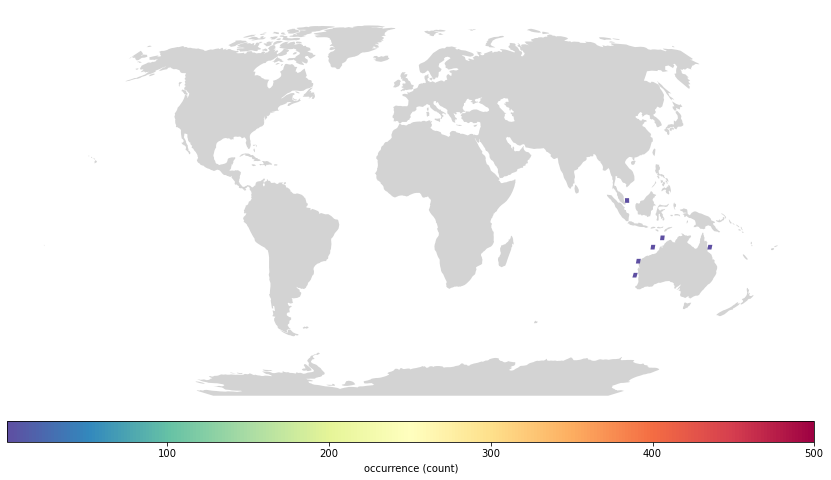

In [57]:
import numpy as np
import shapely
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pycrs

# total area for the grid
xmin, ymin, xmax, ymax= [-180., -90., 180., 90]
# how many cells across and down
n_cells=180
cell_size = (xmax-xmin)/n_cells
# projection of the grid
#crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
# create the cells in a loop
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
        
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                 crs="EPSG:4326")
    
# ax = gdf.plot(markersize=.1, figsize=(12, 8),)# column='dob', cmap='jet')
# plt.autoscale(False)
# cell.plot(ax=ax, facecolor="none", edgecolor='grey')
# ax.axis("off")

merged = gpd.sjoin(gdf, cell, how='left', op='within')

# make a simple count variable that we can sum
merged['n_occur'] = 1
# Compute stats per grid cell -- aggregate fires to grid cells with dissolve
dissolve = merged.dissolve(by="index_right", aggfunc="count")
# put this into cell
cell.loc[dissolve.index, 'n_occur'] = dissolve.n_occur.values


crs = pycrs.parse.from_esri_code(54030)
#crs.geogcs.prime_mer.value = 160.0
crs_str = crs.to_proj4()

fig, ax = plt.subplots(1, figsize=(16,8), facecolor='white')

# start map with entire world
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world.dissolve()

world.to_crs(crs_str).plot( ax=ax,
                            color='lightgrey', 
                            edgecolor=None,
                            linewidth=None
                            )

divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

# plot the gridded occurrence cells
cell.to_crs(crs_str).plot( ax=ax,
                               column='n_occur', 
                               cmap='Spectral_r', 
                               vmin=1, 
                               vmax=500, 
                               edgecolor=None, 
                               legend=True,
                               legend_kwds={'label': "occurrence (count)",
                                            'orientation': "horizontal"},
                               cax=cax,
                               )

plt.autoscale(False)

# # put land on top of points
# world.to_crs(crs_str).plot(ax=ax, 
#                                color='lightgrey', 
#                                edgecolor='black',
#                                linewidth=.5, 
#                                legend=True,
#                                legend_kwds={'label': "occurrence (count)",
#                                             'orientation': "horizontal"},
#                                cax=cax,
#                                )

#ax.outline_patch.set_visible(True)
#world.to_crs("ESRI:54009").plot(ax=ax, color='none', edgecolor='black',linewidth=.5)
ax.axis('off')

In [33]:
print("records:",data.shape[0])
print("Years: %i - %i" % (data["date_year"].astype(float).min(),data["date_year"].astype(float).max()))
print("Species:", len(data['species'].dropna().unique()))
print("Taxa:", len(data['aphiaID'].dropna().unique()))

records: 10
Years: 2004 - 2004
Species: 1
Taxa: 1


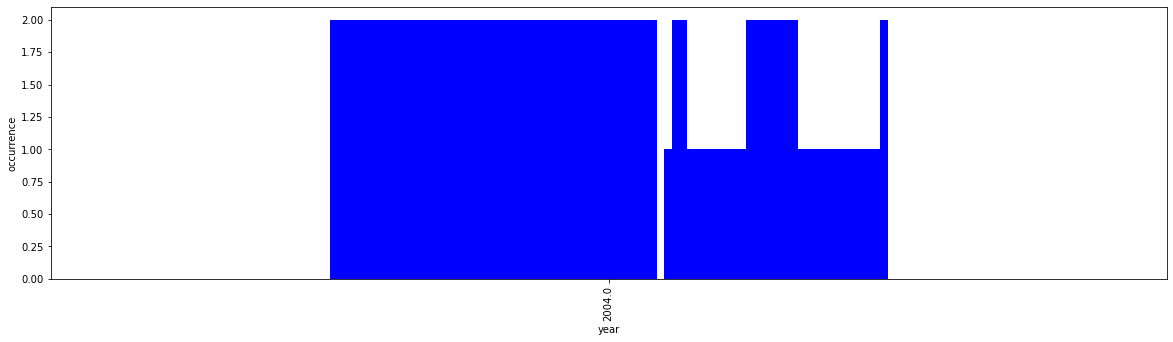

In [32]:
import matplotlib as plt

data['date'] = pd.to_datetime(data['date_year'],format="%Y")

year_group = data.groupby(data['date'].dt.year)

ax = year_group.count().plot(kind="bar", 
                             color='blue',
                             legend=False, 
                             figsize=(20, 5),
                             ylabel='occurrence',
                             xlabel='year',
                            )

#ax.xaxis.set_major_locator(plt.ticker.MaxNLocator(1))

<AxesSubplot:xlabel='n_occur'>

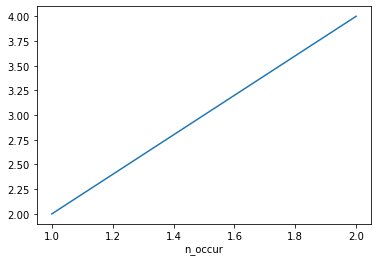

In [63]:
latitude_group = cell.groupby('n_occur')
latitude_group['n_occur'].count().plot()

In [68]:
cell.explore()

In [65]:
data.describe()

genusid   aphiaID  decimalLatitude  subclassid  minimumDepthInMeters  \
count      10.0      10.0        10.000000        10.0                 10.00   
mean   205469.0  288182.0       -17.071510      1340.0                  3.00   
std         0.0       0.0         9.087649         0.0                  2.00   
min    205469.0  288182.0       -28.730000      1340.0                  1.00   
25%    205469.0  288182.0       -21.212500      1340.0                  1.25   
50%    205469.0  288182.0       -17.255025      1340.0                  2.50   
75%    205469.0  288182.0       -13.500012      1340.0                  4.50   
max    205469.0  288182.0         2.825000      1340.0                  6.00   

       phylumid  familyid  maximumDepthInMeters  orderid  decimalLongitude  \
count      10.0      10.0             10.000000     10.0         10.000000   
mean     1267.0  196095.0              5.300000   1363.0        122.204649   
std         0.0       0.0              3.560587      0.0         13.708019   
min      1267.0  196095.0              2.000000   1363.0        104.155000   
25%      1267.0  196095.0              3.000000   1363.0        113.769997   
50%      1267.0  196095.0              4.000000   1363.0        119.264999   
75%      1267.0  196095.0              6.000000   1363.0        123.029999   
max      1267.0  196095.0             12.000000   1363.0        146.005753   

       ...      depth  kingdomid        sss  shoredistance        sst  \
count  ...  10.000000       10.0   9.000000      10.000000   9.000000   
mean   ...   4.150000        2.0  34.453333    2658.700000  26.565556   
std    ...   2.273641        0.0   1.161357    4670.321974   2.582906   
min    ...   2.000000        2.0  31.680000   -2552.000000  22.380000   
25%    ...   2.500000        2.0  33.970000     338.000000  26.110000   
50%    ...   3.000000        2.0  34.780000    1310.000000  27.980000   
75%    ...   6.000000        2.0  35.130000    1483.000000  28.640000   
max    ...   8.500000        2.0  35.320000   11229.000000  28.870000   

       bathymetry  date_year      date_end    date_start      date_mid  
count   10.000000        2.0  2.000000e+00  2.000000e+00  2.000000e+00  
mean    79.972000     2004.0  1.101816e+12  1.082117e+12  1.091923e+12  
std    176.310172        0.0  3.726736e+09  1.301303e+10  4.643146e+09  
min    -96.000000     2004.0  1.099181e+12  1.072915e+12  1.088640e+12  
25%      3.000000     2004.0  1.100498e+12  1.077516e+12  1.090282e+12  
50%      9.000000     2004.0  1.101816e+12  1.082117e+12  1.091923e+12  
75%     26.360000     2004.0  1.103134e+12  1.086718e+12  1.093565e+12  
max    408.000000     2004.0  1.104451e+12  1.091318e+12  1.095206e+12  

[8 rows x 22 columns]

shift map

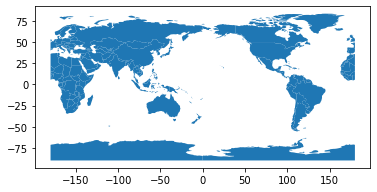

In [31]:
from shapely.geometry import LineString
from shapely.ops import split
from shapely.affinity import translate
import geopandas

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

def shift_map(shift):
    shift -= 180
    moved_map = []
    splitted_map = []
    border = LineString([(shift,90),(shift,-90)])
    for row in world["geometry"]:
        splitted_map.append(split(row, border))
    for element in splitted_map:
        items = list(element)
        for item in items:
            minx, miny, maxx, maxy = item.bounds
            if minx >= shift:
                moved_map.append(translate(item, xoff=-180-shift))
            else:
                moved_map.append(translate(item, xoff=180-shift))
    gdf = geopandas.GeoDataFrame({"geometry":moved_map})
    fig, ax = plt.subplots()
    gdf.plot(ax=ax)
    plt.show()
    
shift_map(180)

In [ ]:
import geopandas as gpd

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

gdf = gpd.GeoDataFrame(
    data, geometry=gpd.points_from_xy(data.decimalLongitude, data.decimalLatitude))

ax = world.plot(
    color='white', edgecolor='black')

gdf.plot(ax=ax, color='red')

In [ ]:
import geoplot

ax = geoplot.kdeplot(
    gdf,
    shade=True, 
    cmap='viridis',
    projection=geoplot.crs.WebMercator(),
    figsize=(12,12),
    )

geoplot.pointplot(gdf, s=1, color='black', ax=ax)
geoplot.webmap(gdf, ax=ax, legend=True)

#geoplot.polyplot(gdf, ax=ax, zorder=1)

In [45]:
import pycrs
crs = pycrs.parse.from_esri_code(54030)

In [44]:
crs.geogcs.prime_mer.value

160.0

In [46]:
crs.geogcs.prime_mer.value

0

<AxesSubplot:>

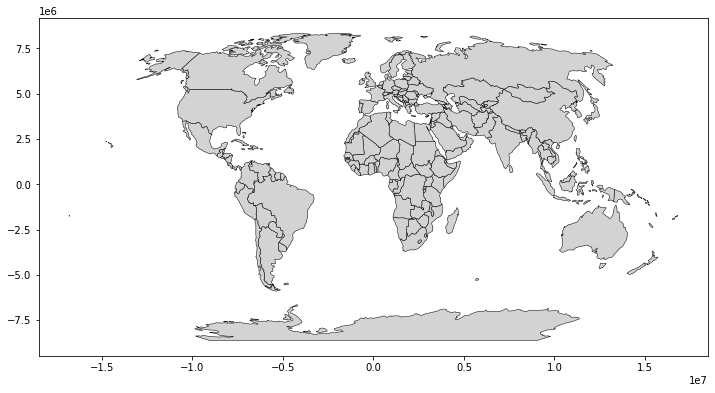

In [61]:
crs = pycrs.parse.from_esri_code(54030)
crs.geogcs.prime_mer.value = 0.0
crs_str = crs.to_proj4()

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.to_crs(crs_str).plot(figsize=(12, 8),
                           color='lightgrey', 
                           edgecolor='black',
                           linewidth=.5, 
                           legend=True,
                           legend_kwds={'label': "occurrence (count)",
                                        'orientation': "horizontal"},
                           )